In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries(path):
    f = open(path)
    queries = []
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                tmp.append(q)
        queries.append(tmp)
    f.close()
    return queries

def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
        queries.append(tmp)
    f.close()
    return queries

In [4]:
path = 'data/requests.uniq.train'
train = read_queries(path)
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test = read_queries(path)
test_lem = read_queries_with_lemmatization(path)
train[:5], train_lem[:5], test[:5], test_lem[:5], len(train), len(test)

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 [['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикая', 'вишня'],
  ['тася', 'кривун', 'танцы', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 51353,
 21174)

### Оценим максимальную точность, которой мы можем достичь

In [7]:
from tqdm import tqdm_notebook

In [20]:
def calculateUpperBound(data):
    cnt = dict()
    
    for line in tqdm_notebook(data):
        prefix = "#_#"
        for word in line:
            if prefix not in cnt.keys():
                cnt[prefix] = Counter()
            cnt[prefix][word] += 1
            prefix += word + "#_#"
    
    max_len = np.max(list(map(len, data)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(data):
        prefix = '#_#'
        for i, word in enumerate(line):
            pred = cnt[prefix].most_common(1)[0][0]
            accrs[i, 1] += 1
            if pred == word:
                accrs[i, 0] += 1
            prefix += word + "#_#"
    return accrs[:, 0] / accrs[:, 1]

In [34]:
tmp = calculateUpperBound(test)
tmp * 100

array([  2.91422634,  61.12688914,  88.6279282 ,  97.17942447,
        98.74418605,  99.329806  ,  99.59804766,  99.76624591,
        99.9201278 , 100.        ,  99.756691  , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.  

In [35]:
tmp_lem = calculateUpperBound(test_lem)
tmp_lem * 100

array([  2.91422634,  57.06968252,  87.5570429 ,  96.98377761,
        98.60465116,  99.31216931,  99.5406259 ,  99.71949509,
        99.9201278 , 100.        ,  99.756691  , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.  

In [25]:
count_words = Counter()

for d in [train_lem]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

In [32]:
def calculateUpperBoundWithPadding(data, bound=3):
    cnt = dict()
    
    for line in tqdm_notebook(data):
        prefix = "#_#"
        for word in line:
            if prefix not in cnt.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    
    max_len = np.max(list(map(len, data)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(data):
        prefix = '#_#'
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if count_words[word] >= 3:
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    return accrs[:, 0] / accrs[:, 1]

In [36]:
tmp_lem_pad = calculateUpperBoundWithPadding(test_lem)
tmp_lem_pad * 100

array([  2.91422634,  28.00486865,  58.11986614,  77.45985163,
        83.79069767,  86.13756614,  86.2474878 ,  87.56428237,
        87.61980831,  85.15519568,  84.67153285,  83.25791855,
        80.3030303 ,  81.70731707,  73.33333333,  73.33333333,
        78.78787879,  72.4137931 ,  78.26086957,  77.77777778,
        73.33333333,  78.57142857,  38.46153846,  76.92307692,
        91.66666667,  75.        ,  60.        ,  60.        ,
        44.44444444,  62.5       ,  85.71428571,  60.        ,
        40.        ,  40.        , 100.        ,  50.        ,
        50.        ,  25.        ,  50.        ,  75.        ,
        75.        ,  75.        ,  75.        ,  33.33333333,
        33.33333333,  33.33333333,  66.66666667,  66.66666667,
        66.66666667,  66.66666667,  33.33333333,  66.66666667,
        66.66666667,  50.        ,  50.        ,  50.        ,
       100.        ,  50.        ,  50.        ,  50.        ,
         0.        ,   0.        ,   0.        ,   0.  

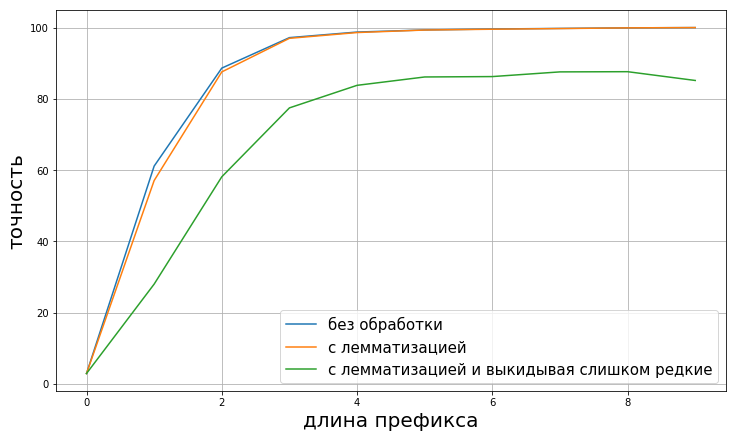

In [38]:
plt.figure(figsize=(12, 7))
grid = np.arange(0, 10, 1)
plt.plot(grid, tmp[:len(grid)] * 100, label='без обработки')
plt.plot(grid, tmp_lem[:len(grid)] * 100, label='с лемматизацией')
plt.plot(grid, tmp_lem_pad[:len(grid)] * 100, label='с лемматизацией и выкидывая слишком редкие')
plt.legend(fontsize=15)
plt.xlabel('длина префикса', fontsize=20)
plt.ylabel('точность', fontsize=20)
plt.grid()
plt.show()

In [41]:
calculateUpperBoundWithPadding(train_lem) * 100

array([  2.61728107,  26.36554404,  58.41036953,  79.75611359,
        84.75142279,  87.38883219,  88.38395823,  88.83601031,
        89.35091278,  88.41922409,  86.88688689,  86.16462347,
        86.60968661,  84.16289593,  82.85714286,  89.24731183,
        86.48648649,  84.375     ,  85.10638298,  89.47368421,
        87.5       ,  88.        ,  95.23809524,  78.94736842,
        77.77777778,  86.66666667,  85.71428571,  84.61538462,
        83.33333333,  88.88888889,  77.77777778, 100.        ,
       100.        , 100.        ,  75.        , 100.        ,
       100.        ,  75.        , 100.        , 100.        ,
       100.        , 100.        , 100.        ,  50.        ,
        50.        , 100.        ,  50.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        ,  50.        , 100.        ,
        50.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.  

In [42]:
calculateUpperBound(train_lem) * 100

array([  2.61728107,  49.61043818,  83.2883095 ,  95.34577965,
        96.40656601,  97.98075521,  98.80161367,  99.56375174,
        99.83096687,  99.94209612,  99.7997998 ,  99.82486865,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.  

In [47]:
def simpleModel(train, test):
    cnt = dict()
    
    for line in tqdm_notebook(train):
        prefix = "#_#"
        for word in line:
            if prefix not in cnt.keys():
                cnt[prefix] = Counter()
            cnt[prefix][word] += 1
            prefix += word + "#_#"
    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(test):
        prefix = '#_#'
        for i, word in enumerate(line):
            if prefix in cnt.keys():
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1
            prefix += word + "#_#"
    return accrs[:, 0] / accrs[:, 1]

In [48]:
simpleModel(train, test) * 100

array([ 2.91422634, 11.99918856,  5.88986918,  3.67653053,  2.26744186,
        2.01058201,  1.06230261,  0.88826554,  0.95846645,  0.8097166 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [49]:
simpleModel(train_lem, test_lem) * 100

array([ 2.91422634, 12.19697738,  6.27319744,  3.82326567,  2.38372093,
        2.09876543,  1.17714614,  0.98176718,  1.11821086,  0.8097166 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [51]:
def advancedModel(train, test):
    cnt = dict()
    
    for line in tqdm_notebook(train):
        prefix = "#_#"
        for word in line:
            if prefix not in cnt.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(test):
        prefix = '#_#'
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if count_words[word] >= 3:
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    return accrs[:, 0] / accrs[:, 1]

In [53]:
advancedModel(train_lem, test_lem) * 100

array([ 2.91422634, 11.78618521,  8.29936112,  5.24170539,  2.8255814 ,
        2.31040564,  1.34941143,  1.12201964,  1.11821086,  0.67476383,
        0.243309  ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])